   Unnamed: 0                                               text  \
0           0  ChatGPT para Mac: accede a la IA desde la barr...   
1           1  ¿Quieren aprender de ChatGPT 101? Gratis. \n\n...   
2           2  Cómo puede sacar provecho un emprendedor para ...   
3           3  Si no estás usando ChatGPT para tu trabajo o p...   
4           4  Alguien por ahí que también salude y le agrade...   

                                            hashtags  \
0                                                NaN   
1                                                NaN   
2  Emprendedores, InteligenciaArtificial, Chatbot...   
3                                                NaN   
4                                                NaN   

                                          clean_text  cluster  \
0  chatgpt para mac accede a la ia desde la barra...        0   
1  quieren aprender de chatgpt  gratis \n\nprximo...        1   
2  cmo puede sacar provecho un emprendedor para s...       

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Accuracy: 0.9478584729981379

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       172
           1       0.93      1.00      0.96       206
           2       0.96      0.92      0.94       159

    accuracy                           0.95       537
   macro avg       0.95      0.94      0.95       537
weighted avg       0.95      0.95      0.95       537



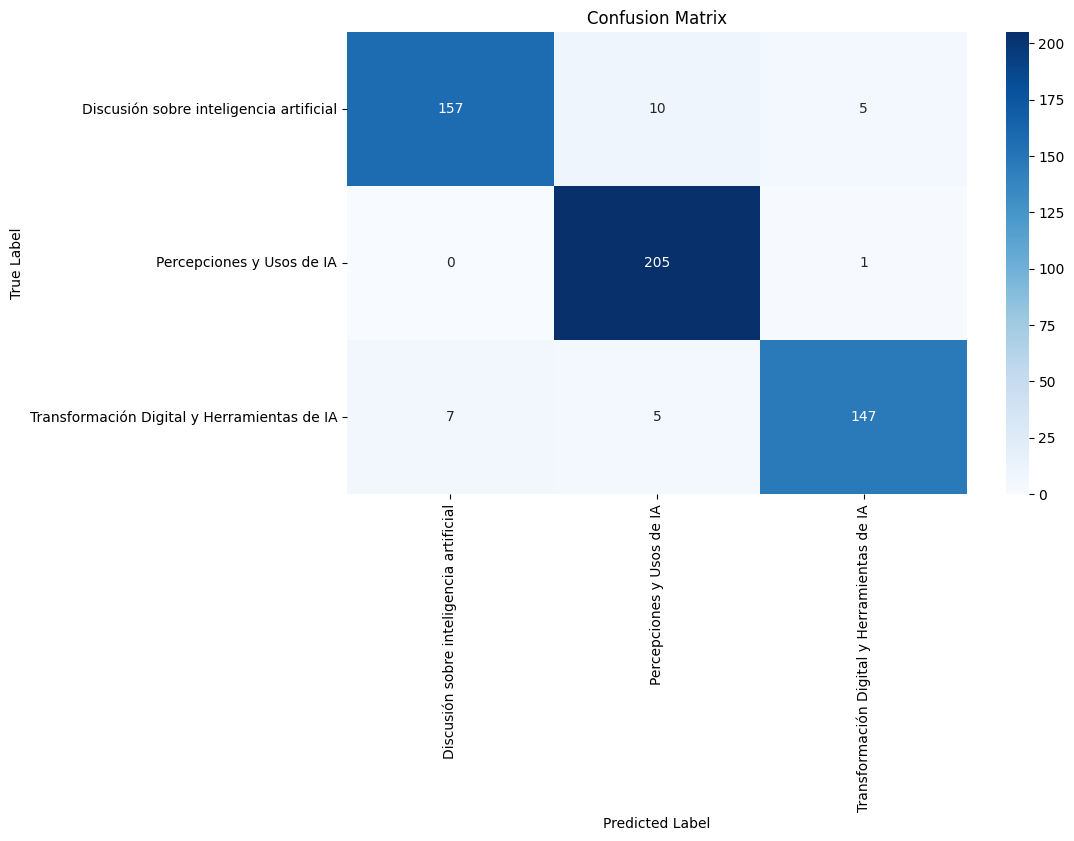

              precision    recall  f1-score     support
0              0.957317  0.912791  0.934524  172.000000
1              0.931818  0.995146  0.962441  206.000000
2              0.960784  0.924528  0.942308  159.000000
accuracy       0.947858  0.947858  0.947858    0.947858
macro avg      0.949973  0.944155  0.946424  537.000000
weighted avg   0.948562  0.947858  0.947538  537.000000


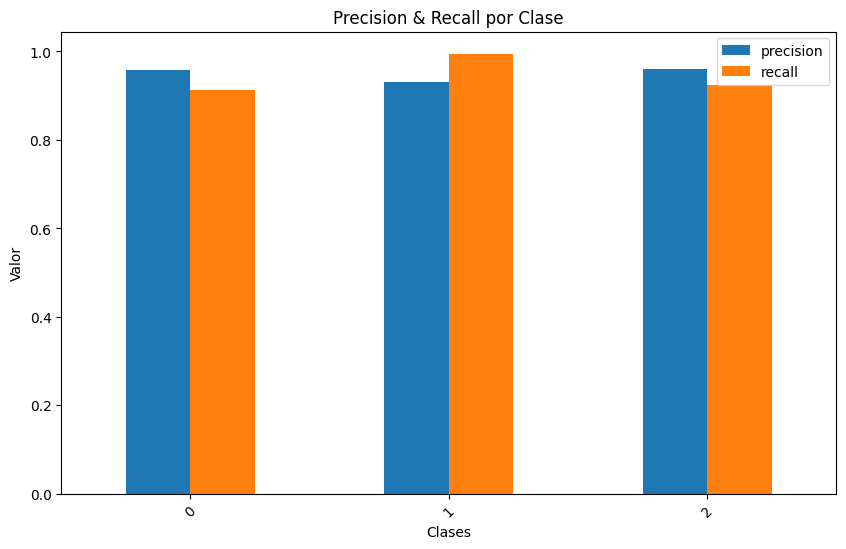

Tweet: '¡Esto es increíble!' -> Clase Predicha: 'Transformación Digital y Herramientas de IA'
Tweet: 'No me gustó para nada' -> Clase Predicha: 'Transformación Digital y Herramientas de IA'


In [ ]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. Cargar dataset
data = pd.read_excel("datos_clusters.xlsx")  # Cambia este nombre según tu archivo
print(data.head())

# 2. Preprocesamiento
data.dropna(subset=["clean_text"], inplace=True)
data.drop_duplicates(subset=["clean_text"], inplace=True)

label_encoder = LabelEncoder()
data["cluster_name"] = label_encoder.fit_transform(data["cluster_name"])

X_train, X_test, y_train, y_test = train_test_split(
    data["clean_text"],
    data["cluster_name"],
    test_size=0.2,
    random_state=42,
    stratify=data["cluster_name"]
)

# 3. Cargar modelo y tokenizer de RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)
roberta_model.eval()

# 4. Función para extraer embeddings
def extract_embeddings(texts, tokenizer, model, device, max_length=128):
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                max_length=max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embedding)
    return torch.cat([torch.tensor(embed) for embed in embeddings], dim=0).numpy()

# Extraer embeddings
X_train_embeddings = extract_embeddings(X_train.tolist(), tokenizer, roberta_model, device)
X_test_embeddings = extract_embeddings(X_test.tolist(), tokenizer, roberta_model, device)

# 5. Entrenar modelo
clf = LogisticRegression(max_iter=1000, solver="liblinear")
clf.fit(X_train_embeddings, y_train)

# 6. Evaluar el modelo
y_pred = clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. Visualización de resultados
# Matriz de confusión
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Tabla con métricas de clasificación
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Gráfico de precisión y recall por clase
report_df.iloc[:-3, [0, 1]].plot(kind='bar', figsize=(10, 6))
plt.title("Precision & Recall por Clase")
plt.xlabel("Clases")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# 8. Probar con nuevos tweets
new_tweets = ["¡Esto es increíble!", "No me gustó para nada"]
new_tweets_embeddings = extract_embeddings(new_tweets, tokenizer, roberta_model, device)
new_predictions = clf.predict(new_tweets_embeddings)
decoded_predictions = label_encoder.inverse_transform(new_predictions)
for tweet, label in zip(new_tweets, decoded_predictions):
    print(f"Tweet: '{tweet}' -> Clase Predicha: '{label}'")
